# 전통적인 컴퓨터 비전에서 인공지능으로

## 1. 분류 문제를 해결하기 위하여 수동으로 규칙을 정의할 필요가 없다면 어떨까요?

지난 노트북 세션에서 다양한 기본 이미지 처리 기술을 실험하고 컴퓨터가 "볼 수 있는" 방법을 살펴보았습니다. 그런 다음 카메라 앞에 들고 있는 물체를 사용하여 시스템이 사용자를 인식하도록 시도했습니다. 다양한 방법을 학습했으며, 많은 창의적인 방법들이 규칙을 정하거나 "if-else" 논리를 정의하였습니다. 예를 들어 "승인된" 색상, 위치 또는 조건 조합과 같은 규칙입니다.

그러나 이러한 규칙을 수동으로 정의 할 필요가 없다면 어떨까요?

**기계 학습**은 인공지능의 하위 집합으로, 기계가 교육 데이터를 기반으로 학습하는 능력에 초점을 맞추고 있습니다. 컴퓨터 비전 분야에 적용하여 정확한 색상 코드에 대한 규칙을 정의하지 않고 기계가 "승인 된"또는 "승인되지 않은" 이미지가 무엇인지 배울 수 있다면 어떨까요?

오늘 세션에서는 기본적인 컴퓨터 비전 기술이 기계 학습과 결합되어 다양한 과제를 해결할 수 있는 방법을 살펴보겠습니다.
1. 먼저 기계 학습을 설명하기 위한 간단한 모델을 만드는 작업을 시작하겠습니다.
2. 그런 다음 분류 모델을 구축하는 단계를 살펴보겠습니다.
3. 다음으로 분류 모델을 사용하여 추론하고 정확성을 살펴봅니다.
4. 이 과정에서 사용하는 다양항 방법과 기술들에 대한 한계에 주의하십시오.

## 카드를 3개의 가능한 범주 중 1개로 분류

'출입카드' 챌린지를 다시 한 번 살펴보겠습니다.  <br />
아래에는 3장의 카드(빨간색, 녹색, 검은색)와 카메라 앞에 카드가 놓여 있지 않은 배경 화면이 있습니다. <br />
위 행은 더 멀리 있는 카드를 표시하고, 아래 행은 카메라에 매우 근접한 카드를 표시합니다.

<img src="52_CV_images/cards.png" style="float:left;"/>
<div style="clear:both;"></div>


카드의 유효성 검사를 위해 웹 카메라에 가까이 있어야한다고 가정 할 때, 각 카드 (이미지) 의 색상을 비교하여 세 개의 카드 중 어느 것인지 판별하는 문제가 될 수 있습니다.

In [1]:
import matplotlib.pyplot as plt

def matdraw(img):
    plt.axis('off') # 창에있는 x축 y축 제거
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
# 다수 mat 그리기 함수
def matsdraw(imgs, row, col):
    for idx in range(len(imgs)):
        plt.subplot(row, col, idx + 1)
        plt.axis('off') # 창에있는 x축 y축 제거
        plt.imshow(cv2.cvtColor(imgs[idx], cv2.COLOR_BGR2RGB))
    plt.show()

## 1.1 특성 추출 - 추론을 돕기 위해 사용할 특성 선택

이 실험을 위해 출입 카드 구별을 위해 색상을 사용하기로 결정했습니다. 그러나 색상을 구분하기 위하여 어떠한 특징을 사용해야 할까요? 특정 지점(예: 이미지의 중심) 또는 이미지의 평균 색상을 선택하면 될까요? BGR 이미지의 특정 채널을 사용해야 할까요? 아니면 그레이스케일 또는 다른 컬러 공간으로 변환해야 할까요?

선택된 특성은 솔루션의 견고성에 영향을 줄 수 있으며 관련이 없는 경우 전혀 도움이 되지 않습니다.

예를 들어, 카메라 이미지 크기를 사용하여 인증된 카드인지 여부를 확인하려고하면, 카메라 앞에 어떤 카드가 있는지에 관계없이 카메라 이미지 크기가 변경되지 않으므로 이미지 크기는 관련성이 없는 특성입니다. 

다양한 특성을 실험해 볼 수 있습니다. <br />
그러나 우선 평균 색상 특성을 사용하여 간단한 실험을 해보겠습니다:

In [2]:
import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# 이미지를 메모리로 읽어 보겠습니다.
red_card = cv2.imread("52_CV_images/cardred_close.png")
green_card = cv2.imread("52_CV_images/cardgreen_close.png")
black_card = cv2.imread("52_CV_images/cardblack_close.png")
background = cv2.imread("52_CV_images/cardnone.png")

**전처리 및 특성 추출**

때로는 입력 데이터가 모델에서 허용하는 일관된 형식인지 확인하기 위해 전처리를 수행해야 할 수도 있습니다.

데이터를 전처리할 수 있는 방법에는 어떤 것들이 있습니까?
1. 표준 크기의 크기 조정.
2. 이미지 방향 변경.
3. 특정 색 공간으로 변환.

예제에서 사용하는 입력은 (640x480) 포맷의 풍경 이미지로 기본 BGR 색 공간입니다. 그러나 예측 모델은 이미지의 모든 픽셀을 사용하지는 않습니다. 대신 평균 색상을 모델의 특성으로 사용하여 모델이 속한 클래스를 추론합니다. 따라서 각 이미지에서 평균 색상을 추출하는 방법을 정의합니다. 

In [3]:
# 특성을 추출하는 함수 정의(평균 색상)
def averagecolor(image):
    return np.mean(image, axis=(0, 1))

색상은 3개의 채널(단일 숫자 값이 아님)을 가지고 있기 때문에 np.mean을 사용했습니다. np.mean 함수가 어떻게 작동하는지 이해하려면 다음 문서를 참조하십시오. https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html#numpy.mean

**탐구: 빨강 및 녹색 카드의 추출 된 특성(평균 색상)은 무엇입니까? **

In [4]:
print (averagecolor(red_card))

[ 27.35627604   4.48305664 154.21746094]


In [5]:
print (averagecolor(green_card))

[119.53976563 133.40338216  61.1089388 ]


생성된 값이 다르다는 것을 알 수 있습니까? 두 색상의 평균 값은 서로 매우 다릅니다. 이것은 좋은 것입니다! 이것은 평균 색상이 이 간단한 문제에 좋은 특성이라는 것을 의미합니다.

**이미지 크기를 특성으로 사용하기로 선택했다면 어떨까요?**

In [6]:
print (red_card.shape)

(480, 640, 3)


In [7]:
print (green_card.shape)

(480, 640, 3)


모양만 알고 있으면 빨간색 카드와 녹색 카드를 구별할 수 있을까요? 
아니요! 두 카드의 모양이 똑같기 때문입니다. 

평균 색상을 알고 있다면 어떨까요?

위에서 볼 수 있듯이 빨간색 카드와 녹색 카드의 평균 색상은 매우 다릅니다. 그러나 두 카드의 이미지 크기는 정확히 동일합니다! 카드를 구별하기 위해 특성을 사용하기 때문에 카드의 유형을 추론하는 데 도움이 되도록 평균 색상을 사용하겠습니다.

이제 각 이미지 파일의 평균 색상 값과 레이블을 입력하는 변수를 만듭니다. 나중에 모델 훈련에 사용할 것입니다. 이 훈련이 어떻게 이루어지는지 기억하시나요?

In [8]:
# 분류를 위해 특성(평균 색상) 및 해당 레이블(빨간색/녹색/검정색/없음) 저장
trainX = []
trainY = []

# 카드들에 대해 반복하고 평균 색상 출력
for (card,label) in zip((red_card,green_card,black_card,background),("red","green","black","none")):
    print((label, averagecolor(card)))
    trainX.append(averagecolor(card))
    trainY.append(label)

('red', array([ 27.35627604,   4.48305664, 154.21746094]))
('green', array([119.53976563, 133.40338216,  61.1089388 ]))
('black', array([70.36474609, 61.85563477, 67.1775651 ]))
('none', array([247.9326888 , 241.13666016, 241.89832357]))


색상 채널의 배열이 [Blue, Green, Red] 순서임을 기억하세요.

빨간색 카드는 다른 카드보다 Red 채널 값이 높습니다. 녹색 카드의 경우 Blue와 Green 채널의 값이 높습니다.
trainX는 특성 벡터(특성)을 저장하고 trainY 는 해당 레이블을 저장합니다.

trainX와 trainY에 저장된 항목이 궁금하다면 배열을 출력하여 확인해 보십시오(위의 출력과 비교). 
이 시점에서 데이터가 저장되는 방식을 이해하는 것이 도움이됩니다.

In [9]:
print(trainX)
print(np.array(trainX).shape)      #3개의 채널이 배열에 저장되는 방식을 참고하십시오.

[array([ 27.35627604,   4.48305664, 154.21746094]), array([119.53976563, 133.40338216,  61.1089388 ]), array([70.36474609, 61.85563477, 67.1775651 ]), array([247.9326888 , 241.13666016, 241.89832357])]
(4, 3)


In [10]:
print(trainY)
print(np.array(trainY).shape)

['red', 'green', 'black', 'none']
(4,)


더 많은 이미지를 사용하는 경우 평균 색상이 항상 정확한 값과 동일하지는 않으며, 조명 조건 및 카메라 설정으로 인해 변동될 수 있습니다. 따라서, 모델을 훈련시키기 위해서는 보통 몇 개 이상의 이미지를 사용해야 합니다.

# 1.2 K-최근접 이웃(K-Nearest Neighbour, kNN) 알고리즘

우리가 카메라 앞에서 새로운 카드를 들고 있을 때, 이 카드 중 어느 카드와 가장 유사한지 확인하고 싶습니다. 정확한 색상 코드를 정의하는 대신 
"**새카드가 알려진 기존 카드 중 어느 카드와 가장 유사한가요?**"라는 관점으로 접근할 수 있습니다.

K-최근접 이웃 알고리즘의 개념은 레이블이 지정된 이미지 세트에서 새 이미지와 가장 유사한 k개의 이미지를 검색하는 것입니다. 그리고 비슷한 이미지의 레이블을 기반으로 새 이미지의 레이블을 예측합니다.  

아래 k=1에 대한 실험을 진행하겠습니다. 즉, 새로운 이미지와 평균 색이 가장 유사한 이미지 1개를 찾는 것입니다. 그리고 그 이미지의 레이블을 사용하여 새 이미지의 레이블을 예측합니다.

어떻게 진행되었는지를 알아봅시다!

### 먼저 새 이미지를 메모리로 읽습니다.

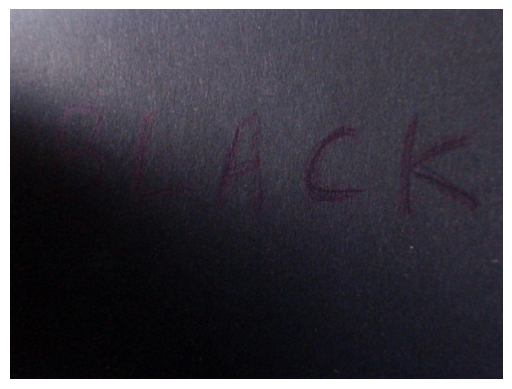

In [11]:
new_card = cv2.imread("52_CV_images/test/16.png")
new_card_features = averagecolor(new_card)
matdraw(new_card)

### 알고 있는 이미지의 특성과 비교하여 새로운 이미지의 특성(평균 색상) 사이의 거리 계산
linealg.norm에 대해 [여기](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) 에서 참조하세요.

In [12]:
calculated_distances = []
for card in (trainX):
    calculated_distances.append(np.linalg.norm(new_card_features-card))
    
print (calculated_distances)

[117.79791641023513, 113.43645699355922, 33.497714831624535, 340.3000785919897]


### 다음은 가장 유사한 카드의 결과입니다:
위의 계산된 거리를 보는 것만으로도 추측이 가능할까요?

> 네, 거리가 가장 가까운 것과 가장 유사합니다

In [13]:
print(trainY[np.argmin(calculated_distances)])

black


이미지/테스트 하위 폴더를 열고 해당 이미지의 실제 색상을 확인하십시오.

우리가 사용한 거리 측정은 "np.linalg.norm ()"이었습니다. 자세한 사항은 https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html 를 참조하거나  인터넷에서 "유클리드 거리(Euclidean Distance)"를 검색해 보세요. 간단히 말해서, (new_card_features)와 (card)의 배열 값이 얼마나 비슷한지를 측정하는 척도로 사용할 수 있습니다.

위에 마지막 코드 블록을 살펴봅시다. 섹션 1.1의 trainY에 저장된 내용을 기억해 보세요.

calculated_distances에 저장된 값을 확인합니다. 
np.argmin의 역할은 무엇입니까? 

힌트: 필요한 경우 numpy.argmin 에 대한 문서를 참조하세요.

In [14]:
print(calculated_distances)

[117.79791641023513, 113.43645699355922, 33.497714831624535, 340.3000785919897]


In [15]:
print(np.argmin(calculated_distances))

2


In [16]:
print(trainY)

['red', 'green', 'black', 'none']


In [17]:
print(trainY[np.argmin(calculated_distances)])

black


### 다른 카드를 테스트해 봅시다.
모델이 실제로 우리가 원하는 것을 예측할 수 있는지 확인하기 위해 이미지가 저장된 폴더를 확인하세요!

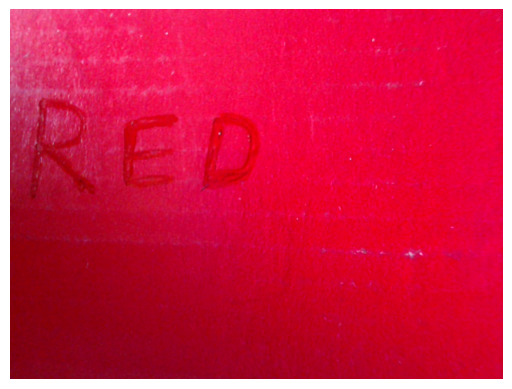

red


In [18]:
# 먼저 새로운 이미지를 메모리로 읽습니다.
new_card = cv2.imread("52_CV_images/test/36.png")
new_card_features = averagecolor(new_card)
matdraw(new_card)

# 새 이미지의 특성(평균 색상)과 알려진 이미지 특성 사이의 거리를 계산합니다.
calculated_distances = []
for card in (trainX):
    calculated_distances.append(np.linalg.norm(new_card_features-card))

# 다음은 가장 유사한 카드의 결과입니다:
print(trainY[np.argmin(calculated_distances)])

### 다른 카드는 어떻습니까?
모델이 실제로 우리가 원하는 것을 예측할 수 있는지 확인하기 위해 이미지가 저장된 폴더를 확인하세요!

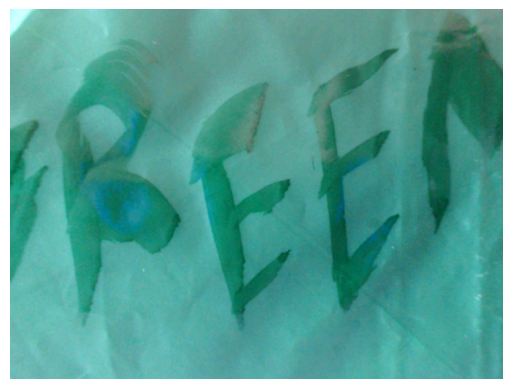

green


In [19]:
# 먼저 새로운 이미지를 메모리로 읽습니다.
new_card = cv2.imread("52_CV_images/test/56.png")
new_card_features = averagecolor(new_card)
matdraw(new_card)

# 새 이미지의 특성(평균 색상)과 알려진 이미지 특성 사이의 거리를 계산합니다.
calculated_distances = []
for card in (trainX):
    calculated_distances.append(np.linalg.norm(new_card_features-card))

# 다음은 가장 유사한 카드의 결과입니다:
print(trainY[np.argmin(calculated_distances)])

### 모든 테스트 카드를 분류해 봅시다.

우리의 단순한 모델이 지금까지 카드를 올바르게 분류한 것 같습니다. 

테스트 하위 폴더에 있는 모든 카드를 반복적으로 분류해 보겠습니다.

In [20]:
from sklearn.metrics import classification_report
# 테스트 이미지에 대한 진리표입니다. 이미지를 보려면 컴퓨터의 폴더를 여십시오.
realtestY = np.array(["black","black","black","black","black",
                     "red","red","red","red","red",
                     "green","green","green","green","green",
                     "none","none","none","none","none"])

def evaluateaccuracy(filenames,predictedY):
    predictedY = np.array(predictedY)
    if (np.sum(realtestY!=predictedY)>0):
        print ("Wrong Predictions: (filename, labelled, predicted) ")
        print (np.dstack([filenames,realtestY,predictedY]).squeeze()[(realtestY!=predictedY)])
    # 전체 예측의 백분율로 일치하는 (정확한) 예측을 계산합니다.
    return "Correct :"+ str(np.sum(realtestY==predictedY)) + ". Wrong: "+str(np.sum(realtestY!=predictedY)) + ". Correctly Classified: " + str(np.sum(realtestY==predictedY)*100/len(predictedY))+"%"

위의 코드 블록에 대한 출력이 없어서 놀라셨나요? 정확도 평가를 하기 위한 기능만 정의했기 때문입니다. 파이썬 기능에 대해 자세히 알아보려면[이 링크](https://www.datacamp.com/community/tutorials/functions-python-tutorial) 를 참조하십시오.

아래 코드 블록을 실행하여 출력을 확인할 수 있습니다.

In [21]:
import os
path = "./52_CV_images/test/"
predictedY = []
filenames = []
for filename in os.listdir(path):
    print(path+filename)
    img = cv2.imread(path+filename)
    img_features = averagecolor(img)
    calculated_distances = []
    for card in (trainX):
        calculated_distances.append(np.linalg.norm(img_features-card))
    prediction = trainY[np.argmin(calculated_distances)]
    
    print (filename + ": " + prediction + "\n") # 추론을 출력합니다.
    filenames.append(filename)
    predictedY.append(prediction)

# 정확도 평가(sklearn 패키지는 유용한 보고서를 제공합니다)
print ()
print(classification_report(realtestY, predictedY))

# 정확도 평가(잘못 분류된 항목의 파일 이름을 출력하기 위한 자체 사용자 정의 메소드)
print ()
print (evaluateaccuracy(filenames,predictedY))


./52_CV_images/test/16.png
16.png: black

./52_CV_images/test/17.png
17.png: black

./52_CV_images/test/18.png
18.png: black

./52_CV_images/test/19.png
19.png: black

./52_CV_images/test/20.png
20.png: black

./52_CV_images/test/36.png
36.png: red

./52_CV_images/test/37.png
37.png: red

./52_CV_images/test/38.png
38.png: red

./52_CV_images/test/39.png
39.png: red

./52_CV_images/test/40.png
40.png: red

./52_CV_images/test/56.png
56.png: green

./52_CV_images/test/57.png
57.png: green

./52_CV_images/test/58.png
58.png: none

./52_CV_images/test/59.png
59.png: green

./52_CV_images/test/60.png
60.png: green

./52_CV_images/test/76.png
76.png: none

./52_CV_images/test/77.png
77.png: none

./52_CV_images/test/78.png
78.png: none

./52_CV_images/test/79.png
79.png: none

./52_CV_images/test/80.png
80.png: none


              precision    recall  f1-score   support

       black       1.00      1.00      1.00         5
       green       1.00      0.80      0.89         5
        none

**정밀도(precision) 및 재현율(recall)은 무엇을 의미합니까?**
기초 단계에서 학습했던 내용을 기억하십니까?

참 긍정, 거짓 긍정, 참 부정 및 거짓 부정의 개념을 기억하십시오.

예를 들어, 우리가 빨간색 클래스를 평가하는 경우 
- 빨간색 이미지를 빨간색으로 올바르게 분류하면 참 긍정입니다.
- 빨간색 이미지를 검은색으로 잘못 분류하면 참 부정입니다.
- 빨간색이 아닌 다른 이미지를 빨간색으로 분류하면 거짓 긍정입니다.
- 빨간색이 아닌 이미지를 빨간색이 아닌 이미지로 올바르게 분류하면 참 부정입니다.

정밀도는 참 긍정 값을 (참 긍정 + 거짓 긍정)으로 나눈 값이며, 빨간색으로 분류된 것 중 얼마나 많은 것이 실제로 빨간색인지를 의미합니다.

재현율은 참 긍정 값을 (참 긍정 + 거짓 부정)으로 나눈 값이며, 모든 빨간색 이미지 중에서 올바르게 빨간색으로 분류된 이미지를 의미합니다.

정밀도와 재현율에 대한 자세한 내용은 인터넷 검색이나, 다음 링크에서 확인해 보세요.
https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

**잘못 분류 된 이미지를 조사합시다**

해당 폴더를 열고 이미지를 확인하십시오.

58.png가 잘못 분류 된 것 같습니다. 왜일까요?

58.png

<img src="52_CV_images/test/58.png" style="width:400px; float:left;" />
<div style="clear:both;"></div>

초기 훈련 이미지 세트를 살려봅시다. <br />
58.png 는 '녹색' 카드 훈련 이미지보다 훨씬 밝게 보입니다. 이는 훈련 이미지가 "없음"으로 잘못 인식된 이유일 수 있습니다(이것은 4장의 훈련 이미지 중 '가장 밝은' 이미지입니다).

<img src="52_CV_images/cards.png" style="float:left;"/>
<div style="clear:both;"></div>



사람은 58.png 가 녹색으로 분류되어야 한다는 것을 쉽게 알 수 있습니다.

그러나 시스템을 "훈련"하는 데 사용 된 기능은 "평균 색상"이었고 하나의 교육 이미지 만 제공했음을 기억하십시오.

58.png의 평균 색상은 훈련 이미지(cardgreen_close.png) 보다 배경의 평균 색상(background.png)에 더 가까운 것 같습니다.

이미지의 평균 색상을 각각 계산하고 잘못 분류된 이유를 밝히는 것이 연습 문제로 남아있습니다. 이 노트북 뒷부분의 챌린지 1번 문제 입니다.

모델을 향상시킬 수 있는 방법을 생각해 볼 수 있습니까?

### 테스트 이미지 폴더를 엽니다!
테스트 이미지 폴더를 열어서 확인해 보세요. 각 이미지의 조명 조건이 다른 것 처럼 보이시나요? 지금까지 우리는 각 색깔 카드에 대해 하나의 예시를 사용하여 시스템을 훈련하였습니다. 더 많은 훈련 이미지가 도움이 될 수 있다고 생각하십니까?

 ## 1.3 더 많은 샘플을 사용한 훈련
 
더 많은 샘플로 훈련하는 것은 어떻습니까?  <br />
trainX와 trainY를 얻기 위해 섹션 1.1에서 한 일을 상기하십시오. 잊어버린 경우에는 코드를 더 잘 이해할 수 있도록 섹션 1.1을 다시 읽으십시오.

In [22]:
trainX2 = []
trainY2 = []
import os

# 이미지 하위 디렉토리 4개 폴더에 있는 훈련 이미지를 반복합니다.
path = "52_CV_images/"
class_name = ['red','green','black','none']

# 보통 data 불러와서 구성을 이런식으로 함
for label in class_name:
    print ("Loading training images for the label: "+label)
    
    # 하위 폴더의 모든 이미지를 읽어옵니다.
    for filename in os.listdir(path+label+"/"): 
        img = cv2.imread(path+label+"/"+filename)
        img_features = averagecolor(img)
        trainX2.append(img_features)
        trainY2.append(label)

Loading training images for the label: red
Loading training images for the label: green
Loading training images for the label: black
Loading training images for the label: none


### 실습: 모델을 훈련시키기 위해 얼마나 많은 이미지를 사용하고 있습니까?

In [23]:
print (len(trainX2))
print (len(trainY2))

60
60


### 실습: 하위 폴더로 확인하십시오!
컴퓨터의 이미지 디렉토리에서 빨간색, 녹색, 검은색 및 없음 하위 폴더를 엽니다. 각 폴더에서 몇 개의 이미지를 로드하고 있습니까?

### 더 많은 훈련 이미지를 로드한 후 테스트를 다시 실행해 보겠습니다.

In [24]:
import os
path = "52_CV_images/test/"
filenames = []
predictedY = []
for filename in os.listdir(path):
    img = cv2.imread(path+filename)
    img_features = averagecolor(img)
    calculated_distances = []
    for card in (trainX2):
        calculated_distances.append(np.linalg.norm(img_features-card))
    prediction =  trainY2[np.argmin(calculated_distances)]
    
    print (filename + ": " + prediction)
    filenames.append(filename)
    predictedY.append(prediction)

# 정확도 평가(sklearn 패키지는 유용한 보고서를 제공합니다)
print ()
from sklearn.metrics import classification_report
print(classification_report(realtestY, predictedY))

# 정확도 평가
print (evaluateaccuracy(filenames,predictedY))

16.png: black
17.png: black
18.png: black
19.png: black
20.png: black
36.png: red
37.png: red
38.png: red
39.png: red
40.png: red
56.png: green
57.png: green
58.png: green
59.png: green
60.png: green
76.png: none
77.png: none
78.png: none
79.png: none
80.png: none

              precision    recall  f1-score   support

       black       1.00      1.00      1.00         5
       green       1.00      1.00      1.00         5
        none       1.00      1.00      1.00         5
         red       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Correct :20. Wrong: 0. Correctly Classified: 100.0%


**방금 한 일은 무엇입니까?**

섹션 1.1에서 kNN에 대한 모델을 "훈련"한 다음 모델을 사용하여 섹션 1.2에서 새 카드가 속한 클래스를 예측하는 방법을 보았습니다. 섹션 1.3에서는 훈련 데이터를 늘리면 정확도를 향상시키는 데 도움이 될 수 있는 방법을 모색하여, "58.png"를 실제로 녹색이 아닌 것으로 잘못 분류하는 초기 오류를 제거하였습니다.

우리는 가장 가까운 이웃을 기반으로 새로운 이미지의 클래스를 예측하기 위해 K-최근접이웃(KNN) 알고리즘의 매우 단순화 된 예를 사용했습니다. . 위의 예제에서 k의 값은 1이었습니다. 따라서, 우리는 가장 가까운 이웃(가장 작은 계산 된 거리를 가진 이웃)을 검색하고, 가장 가까운 이웃의 클래스를 기반으로 테스트 이미지의 값을 예측했습니다.


### 다시 한 번 생각해 보세요.

이 방법은 이전 세션에서 사용 된 방법과 어떻게 다릅니까?

코드의 길이가 더 길어졌나요? 규칙을 정해주는 방식과 기계가 스스로 학습하도록 하는 것 중에 어떤 것을 더 선호하십니까? 대부분의 사용자는 규칙을 수동으로 정의하는 것보다 교육 이미지 세트를 제공하는 것이 더 쉬울 것입니다.

어떻게 하면 시스템을 더 개선할 수 있을까요? 다양한 방법을 혼용하는 것이 훨씬 더 좋을까요? 모든 종류의 이미지에서 사용할 수 있습니까? 그 이유는 무엇인가요?

<br />
<video controls src="52_CV_images/black_red_green.mp4" style="width:400px;" />

## 2. 분류 모델 구축을 위한 기본 단계

섹션 1에서는 kNN 알고리즘을 기반으로 매우 단순한 분류 모델을 구현하는 작업을 빠르게 진행하였습니다.
실제로 컴퓨터 비전 모델의 훈련은 일반적으로 Keras, Tensorflow, Caffe 및 MXNet과 같은 프레임워크 또는 파이썬 용 Scikit-Learn과 같은 라이브러리를 사용하여 수행됩니다.

훈련은 수시간, 수일, 심지어 수주가 걸릴 수 있으며, 종종 GPU와 더 강력한 컴퓨팅 기능을 갖춘 기계가 필요한 경우도 많습니다. 우리가 kNN용으로 만든 모델은 개념을 설명하기 위해 numpy 배열을 사용한 단순한 모델이었습니다.

이제 분류 모델을 구축하는 데 일반적으로 필요한 단계를 살펴보겠습니다(이 중 일부는 이 연습에서 이미 수행되었습니다):
1. 데이터 수집
2. 데이터 준비(클리닝, 라벨링 등)
3. 데이터를 훈련 세트와 시험 세트로 분할
4. 알고리즘 선택 및 모델 훈련
5. 성능 평가

사용할 알고리즘을 선택하는 것은 5 단계 중 하나에 불과합니다. 기계 학습 알고리즘의 경우 데이터 준비가 매우 중요합니다. 잘못된 정보를 입력하면 모델이 자연스럽게 잘못됩니다.

마찬가지로, 데이터 전처리와 모형에 사용하는 특성도 중요합니다. 다양한 색상의 꽃을 인식하는 모델을 훈련시키는 회색조 이미지(중요한 색상의 특징은 제외하고)만 사용한다고 상상해 보십시오. 반대로 광학 문자 인식(OCR)의 경우 색상 정보가 그다지 유용하지 않을 수 있으며 모델에 대해 선택된 특성에 포함되지 않을 수 있습니다.

## 3. 지금까지 kNN이었습니다. SVM(Support Vector Machines)은 어떻습니까?

생각해 보면 kNN 알고리즘은 실제로 많은 것을 알지 못했고 기본적으로 훈련 데이터를 저장하고, 새로운 이미지에 대한 추론이 필요할 때마다 조회를 수행하였습니다.

수학 시간에 배운 선형 방정식의 유도 공식 **y = mx + c** 를 기억하시나요?

만약 우리가 다른 클래스들을 예측하는데 사용될 수 있는 방정식이나 공식을 도출할 수 있다면 어떨까요?

## 지원 벡터(Support Vector)란 무엇입니까??

X에서 O를 분류해야 한다고 상상해 보십시오. 모든 X와 O를 가장 잘 구분하는 선을 하나 그려 보세요.

<img src="52_CV_images/svm1.jpg" style="width: 300px; float:left;" />
<div style="clear:both;"></div>

우리는 X와 O를 분류하기 위해 선을 하나 그릴 수 있습니다(아래 파란색 선). 이것은 지원 벡터의 간단한 예입니다. 선의 왼쪽/상단에 있는 모든 항목은 X로 분류될 수 있으며, 선의 오른쪽/하단에 있는 모든 것은 O로 분류될 수 있습니다.

<img src="52_CV_images/svm2.jpg" style="width: 300px; float:left;" />
<div style="clear:both;"></div>


참고:  SVM에 대한 수학적 배경은 이 세션의 범위를 벗어나지만 자세히 읽어 보는 것이 좋습니다.  https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/ (링크에서 단일 선형 벡터가 2개의 서로 다른 클래스를 분리하는 방법을 다이어그램으로 보여 줍니다.)

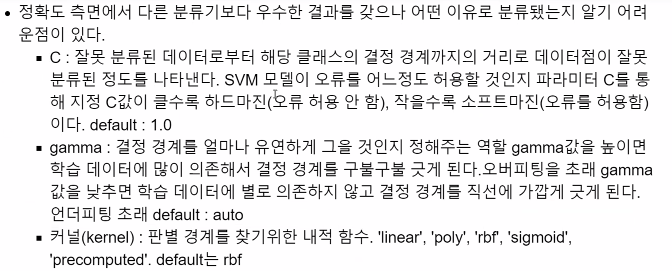
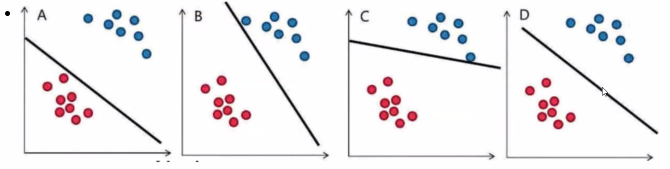

어느 선이 가장 좋은 선인가?

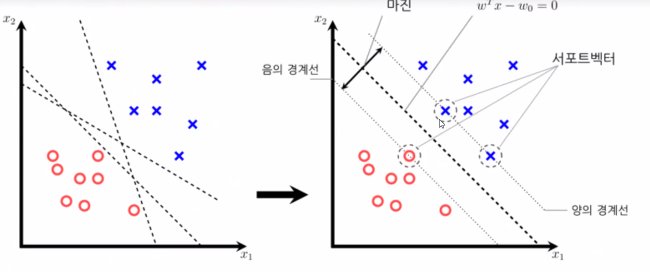

마진이 가장 큰 선이 좋은 선이라는 개념을 가진 것이 suport vector임 

계속해서 파이썬 Scikit-learn 라이브러리를 사용하여 SVM(Support Vector Machines)이 실제로 작동하는 방법에 대해 살펴보겠습니다. 먼저, 지원 벡터의 '방정식을 도출'하며, 그런 다음 " 방정식을 사용하여" 예측을 실행합니다.

### 첫 번째 모델 훈련

In [25]:
# SVM은 숫자 값을 사용하기 때문에 먼저 레이블을 숫자로 인코딩합니다.
from sklearn.preprocessing import LabelEncoder  # 레이블을 숫자로 인코딩

encoder = LabelEncoder()                         # 레이블을 숫자로 인코딩
encodedtrainY2 = encoder.fit_transform(trainY2)  # 레이블을 숫자로 인코딩

from sklearn import svm
#model = svm.SVC(gamma="scale", decision_function_shape='ovr')
model = svm.SVC(gamma=0.001, decision_function_shape='ovr')
model.fit(trainX2, encodedtrainY2)

SVC(gamma=0.001)

LabelEncoder의 역할은 무엇입니까? 함수 결과를 살펴 보겠습니다.
LabelEncoder에 대한 자세한 내용은 [여기](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621) 에서 더 자세히 알아볼 수 있습니다.

In [26]:
print (encodedtrainY2)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


SVM을 깊이 이해하는 것은 이 단원의 범위를 넘어서지만, [여기](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769) 에서 자세한 내용은 언제든지 확인할 수 있습니다.

이제 SVM 모델을 확보했습니다.

### 예측을 실행해 봅시다!

In [27]:
import os
path = "52_CV_images/test/"
filenames = []
predictedY = []
for filename in os.listdir(path):
    img = cv2.imread(path+filename)
    img_features = averagecolor(img)
    prediction = model.predict([img_features])[0]
    
    # 예측을 코드화합니다.
    prediction = encoder.inverse_transform([prediction])[0]
    
    print (filename + ": " + prediction)
    filenames.append(filename)
    predictedY.append(prediction)

# 정확도 평가(sklearn 패키지는 유용한 보고서를 제공합니다)
print ()
print(classification_report(realtestY, predictedY))

# 정확도 평가
print (evaluateaccuracy(filenames,predictedY))

16.png: black
17.png: black
18.png: black
19.png: black
20.png: black
36.png: red
37.png: red
38.png: red
39.png: red
40.png: red
56.png: green
57.png: green
58.png: green
59.png: green
60.png: green
76.png: none
77.png: none
78.png: none
79.png: none
80.png: none

              precision    recall  f1-score   support

       black       1.00      1.00      1.00         5
       green       1.00      1.00      1.00         5
        none       1.00      1.00      1.00         5
         red       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Correct :20. Wrong: 0. Correctly Classified: 100.0%


### 어느 것이 더 정확합니까?

SVM이 kNN보다 더 효과적으로 정확한 분류를 얻을 수 있다고 생각하십니까?

결과는 문제에 따라 달라집니다. SVM의 경우에는 이 세션의 범위를 벗어나 조정해야 하는 다른 매개 변수도 있습니다. 이 매개 변수는 모델 생성 프로세스를 결정합니다. 예를 들어, 모델은 어떤 종류의 지원 벡터를 생성해야 하는지 알아야합니다. 일부 데이터 세트에는 "직선"이 적용되지만 다른 데이터 세트에는 곡선 또는 더 복잡한 지원 벡터가 필요할 수 있습니다.

예를 들어, 아래의 O와 X를 분류하기 위해 직선을 적용하는 것을 생각해 보십시오. 이 문제의 경우 직선 대신 원에 대한 방정식이 필요할 수도 있습니다.

<img src="52_CV_images/svm3.jpg" style="width:400px; float:left;" />
<div style="clear:both;"></div>

자세한 내용은 이 섹션의 끝에 있는 링크를 참조하십시오.

여기까지 trainX2와 trainY2를 사용하여 모델을 학습한 후 별도의 이미지 세트에 대해 우리 모델을 테스트하였으며, 이는 잘 수행되는 것처럼 보였습니다. 그러나 작은 테스트 세트에서 잘 작동하는 것이 항상 잘 작동한다는 것을 의미하지는 않습니다. 

이전에 테스트하지 않았던 다른 이미지로 다시 테스트해 봅시다. 사람의 눈은 그것이 어떤 색인지 쉽게 구별할 수 있습니다. 그러나 지금까지 완벽하게 작동하는 것으로 보였던 모델이 새로운 테스트 이미지를 정확하게 분류하고 있습니까?

<img src="52_CV_images/cardtestagain.png" style="width:400px; float:left;" />
<div style="clear:both;"></div>


In [28]:
imagenew = cv2.imread("52_CV_images/cardtestagain.png")
imagenew_features = averagecolor(imagenew)
prediction = (model.predict([imagenew_features])[0])

# 숫자에서 레이블로 예측 값을 디코딩
print(encoder.inverse_transform([prediction])[0])

green


### 무엇이 잘못되었습니까?

안타깝게도 이미지가 빨간색이 아닌 없음으로 잘못 분류된 것 같습니다. <br />
이 세션의 범위를 벗어난 수학에 대해 깊이 파고들지 않고는 SVM 모델이 왜 이 경우에 잘못 분류되었는지 파헤치기 어려울 것입니다. 간단한 비유는 직선에 대한 방정식에 곡선을 맞추는 것이 어려울 수 있다는 것입니다. y=mx+c가 곡선에 사용하기에 잘못된 방정식이 되는 것처럼 말이다.

**사이드 팁:** 기계 학습을 사용하여 솔루션을 설계 할 때 가장 정확한 모델을 훈련시키는 것을 목표로하지만 모델이 올바른 결과를 제공하지 못할 경우를 대비한 계획 수립에도 시간을 들여야 합니다. 또한 잘못된 결과가 애플리케이션에 미칠 수 있는 영향을 고려하여 위험을 완화하기 위한 조치를 취해야합니다. 예를 들어, 컴퓨터 비전에 의해 안내되는 기계의 일부인 경우, 그것이 무언가에 부딪히기 전에 비상 정지를 시킬 수 있는 다른 센서가 있어야 합니다.

한편, kNN 알고리즘은 동일한 이미지에 대해 어떻게 작업을 진행합니까?

In [29]:
calculated_distances = []
for card in (trainX):
    calculated_distances.append(np.linalg.norm(imagenew_features-card))
print(trainY2[np.argmin(calculated_distances)])

red


### kNN이 항상 더 신뢰할 수 있다는 것을 의미합니까?

이미지를 하나 더 사용해 보겠습니다:

<img src="52_CV_images/cardtestagain2.png" style="width:400px; float:left;" />
<div style="clear:both;"></div>

In [30]:
imagenew = cv2.imread("52_CV_images/cardtestagain2.png")
imagenew_features = averagecolor(imagenew)
calculated_distances = []
for card in (trainX2):
    calculated_distances.append(np.linalg.norm(imagenew_features-card))
    
print("SVM: "+str(encoder.inverse_transform([ model.predict([imagenew_features])[0] ])[0]))
print("kNN: "+str(trainY2[np.argmin(calculated_distances)]))


SVM: green
kNN: none


위 이미지에서 kNN 알고리즘이 이미지를 녹색이 아닌 없음으로 잘못 분류한 이유를 추측할 수 있습니까?

이미지의 평균 색상을 계산하여 그 이유를 알아낼 수 있습니다.

또한 이러한 문제를 완화하기 위해 더 많은 이미지를 사용하여 모델을 교육할 수 있습니다.


참고: SVM에 대한 수학은 이 세션의 범위에 포함되지 않지만, 자세히 읽어보는 것이 좋습니다.  https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/ (링크에서 단일 선형 벡터가 2개의 서로 다른 클래스를 분리하는 방법을 다이어그램으로 보여 줍니다.)

그러나 우리의 실험에서는 2개 이상의 클래스를 분리하기 위해 사용했습니다. https://scikit-learn.org/stable/modules/svm.html#multi-class-classification 에서 SVM을 사용한 다중 클래스 분류에 대해 자세히 알 수 있으며, 코드 샘플을 볼 수 있습니다. 도움이 더 필요한 경우 인터넷 검색을 활용할 수 있습니다.

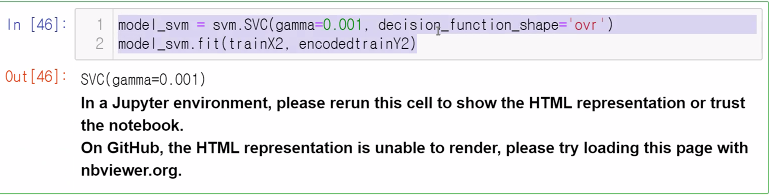
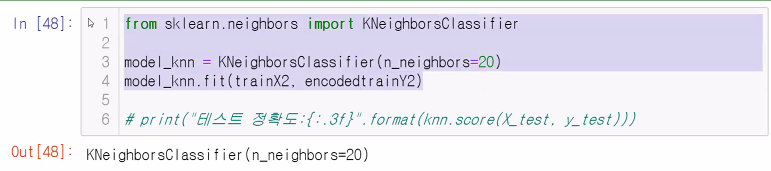

kNN에서 보는 숫자를 줄이면 이 data에 최적화될 수 있음</br>
</br>
중간에 비교에 대한 코드가 있는데 못찍은 ㅋㅋㅋ
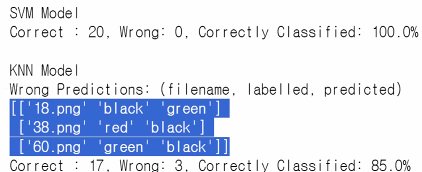

data 상황에 따라서 여러 모델 별로 상황이 다름

## 축하합니다! 

## 이제 여러분의 시간입니다! 

기계 학습에 대하여 빠르게 소개를 완료하였습니다. 규칙 기반 접근 방식에서 기계 학습 방법으로의 진행 과정을 살펴보았습니다. 또한 분류를 위해 kNN 및 SVM 모델을 교육하기 위해 훈련 데이터를 사용했으며 결과와 몇 가지 제한 사항을 살펴 보았습니다.

학습할 수 있는 것이 훨씬 더 많지만 여러분은 이미 기계 학습을 위한 건축을 시작할 수 있습니다!

언제든지 도움이 필요하면 항상 친숙한 인터넷을 활용할 수 있습니다: <br />
- https://docs.opencv.org/4.0.0/d2/d96/tutorial_py_table_of_contents_imgproc.html
- https://scikit-learn.org/stable/documentation.html

**팁:** 이전 세션에서 배운 기본적인 컴퓨터 비전 기술을 여러분의 모델에 어떤 특성들이 유용할지 생각하여 활용할 수 있습니다. 색상 공간, 임계값, 윤곽 감지, 기하학적 변환, 이미지 numpy 배열의 직접 조작 등이 있습니다.  때로는 기본적인 방법이 직면한 과제에 가장 효과적 일 수 있습니다.

여러분이 무엇을 만들든지 목적과 목표를 염두에 두고 다양한 접근 방식을 생각해 보십시오. 또한 기계 학습 알고리즘이 오분류를 할 때 발생할 수 있는 영향을 염두에 두고 위험을 완화하는 방법을 계획해야 합니다. 예를 들어, 모델이 빨간색 카드를 매우 잘 식별하지만 때로는 녹색과 파란색 카드를 혼합한다는 것을 알고 있다면 녹색과 파란색 대신 빨간색 카드를 사용하여 솔루션을 설계하는 것이 좋습니다. 녹색, 검은색 카드가 발견되는 경우에는 보안 담당자가 두 번째 계층 검사를 수행해야 하는 경우와 같이 기타 확인 계층에 추가할 수 있습니다.

오류 가능성이 있는 여러 시나리오에 대하여 다른 기술이나 하드웨어 센서를 사용하여 솔루션의 설계를 보완해 보세요.

### 챌린지 1: "images/test/58.png"의 평균 색상은?

처음에 잘못 분류되었다는 것을 기억하십니까? 그 이유를 살펴보겠습니다.
결과를 변수 "cha1"에 저장합니다.

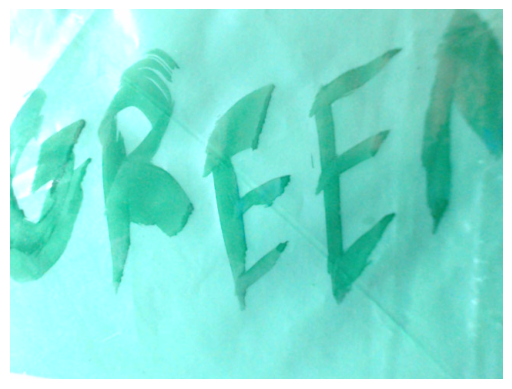

array([208.77603841, 223.6275293 , 120.75616536])

In [31]:
card1 = cv2.imread("52_CV_images/test/58.png")
matdraw(card1)
cha1 = averagecolor(card1)
cha1

### 챌린지 2: "images/background.png"의 평균 색상은?

결과를 변수 "cha2"에 저장합니다.

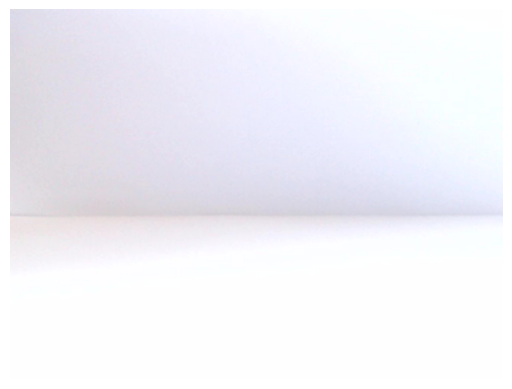

array([247.9326888 , 241.13666016, 241.89832357])

In [32]:
card2 = cv2.imread("52_CV_images/background.png")
matdraw(card2)
cha2 = averagecolor(card2)
cha2

### 챌린지 3: "images/cardgreen_close.png"의 평균 색상은?

결과를 변수 "cha3"에 저장합니다.

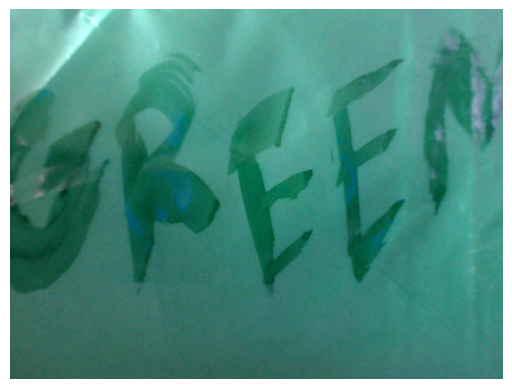

array([119.53976563, 133.40338216,  61.1089388 ])

In [33]:
card3 = cv2.imread("52_CV_images/cardgreen_close.png")
matdraw(card3)
cha3 = averagecolor(card3)
cha3

### 챌린지 4: 58.png vs Background. cha1과 cha2 사이의 거리를 계산하십시오.

섹션 1.2에서 유클리드 거리를 계산하는 방법을 생각해 보세요.

In [34]:
distance = np.linalg.norm(cha1-cha2)
    
print (distance)

128.51161592391296


### 챌린지 5: 58.png vs Green.  cha1과 cha3 사이의 거리를 계산하십시오.

섹션 1.2에서 유클리드 거리를 계산하는 방법을 생각해 보세요.

In [35]:
distance = np.linalg.norm(cha1-cha3)
    
print (distance)

140.2187603130577


챌린지 4(58.png vs. background)의 거리가 더 작습니까? 챌린지 5(58.png vs. green)의 거리가 더 작습니까?

거리가 작을수록 더 큰 유사성을 의미합니다. 58.png는 4개의 "훈련 이미지"를 바탕으로 녹색 카드보다는 배경과 더 유사한 것으로 분류되었습니다.

### 챌린지 6: Modify the function averagecolor to convert the image to greyscale before extracting the features

Recall how you converted an image to greyscale in the previous session. Calculate the accuracy of the kNN model when we use average greyscale instead of averagecolor. (i.e. Run section 1.3 using your updated averagecolor function. Rerun both the training and inference steps) What is the new accuracy? Does it perform better? Why do you think so?

In [36]:
# 다음 함수를 수정할 수 있습니다.
def averagecolor_grey(image):
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(grey, axis=(0, 1))

### 보너스 주제: 분류를 넘어, 우리가 배운 것을 사용하여 이미지 내의 컬러 카드가 어디에 있는지 위치를 파악할 수 있습니까?

우리는 모델의 특성으로 평균 색상을 사용 했으므로 전체 이미지를 분류하는 대신 이미지 내의 각 개별 픽셀을 분류하는 데 사용할 수 있습니까?

"색상 클래스"에 속하는 픽셀을 알면 이미지에서 카드가 어디에 있는지 이해하는 데 도움이 될 수 있습니다. 다음은 _localization_의 예입니다. 

이 실험을 위해 3 개의 샘플 이미지를 사용해 보겠습니다. images/cardblack.png, images/cardred.png, images/cardgreen.png

우선 이미지 내의 빨간색 카드가 어디에 있는지 확인할 수 있습니까?

In [37]:
# sklearn 패키지에서 kNN 분류기를 사용하는 간단한 방법은 다음과 같습니다. 
# 어떻게 작동하는지 알기 때문에 처음부터 작성할 필요는 없습니다.
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(trainX2, trainY2) 

KNeighborsClassifier(n_neighbors=1)

In [38]:
card_localization = cv2.imread("52_CV_images/cardred.png")

# 먼저 픽셀을 모델이 허용하는 형식으로 정렬해야합니다 (2D 배열)
# numpy 배열 방법을 사용하면 쉽게 할 수 있습니다.
temp = card_localization.reshape((307200,3)) 

# 각 픽셀의 색상을 예측
prediction = knnmodel.predict(temp)             

# 우리가 익숙한 이미지 모양으로 예측을 다시 정렬 할 수 있습니다.
masklabels = (prediction.reshape((480,640)))

# 관심 있는 클래스에 대한 마스크를 만듭니다! (이전 세션에서 마스크가 무엇인지 생각해보십시오)
canvas = np.zeros(card_localization.shape[:2],dtype="uint8")
canvas[masklabels=="red"]=255

# 가장 큰 영역의 위치를 찾습니다.
(cnts,_) = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=lambda cnts: cv2.boundingRect(cnts)[1])[:1]  # 위에서 아래로 윤곽을 정렬합니다.
for (i, c) in enumerate(cnts):    
    (x, y, w, h) = cv2.boundingRect(c)                  
    cv2.rectangle(card_localization, (x,y), (x+w,y+h), (0,255,0),2)     # 경계 상자를 빨간색으로 그립니다.

# 결과 표시
cv2.imshow("Localization",canvas)
cv2.imshow("Marked Card",card_localization) #여기에 그려진 경계 상자를 보십시오.
cv2.waitKey(0)
cv2.destroyAllWindows()

동일한 개념을 사용하여 기본적으로 각 픽셀에 클래스 레이블을 할당하는 _Image Segmentation_을 수행 할 수 있습니다. 아래 예에서는 4개의 레이블 "빨간색", "녹색", "검은색" 및 "없음"을 시각화할 수 있습니다(흰색으로 표시).

In [39]:
card_localization = cv2.imread("52_CV_images/cardred.png")

# 먼저 픽셀을 모델이 허용하는 형식으로 정렬해야합니다 (2D 배열)
# numpy 배열 방법을 사용하면 쉽게 할 수 있습니다.
temp = card_localization.reshape((307200,3)) 

# 각 픽셀의 색상을 예측
prediction = knnmodel.predict(temp)             

# 우리가 익숙한 이미지 모양으로 예측을 다시 정렬 할 수 있습니다.
masklabels = (prediction.reshape((480,640)))

# 관심 있는 클래스에 대한 마스크를 만듭니다! (이전 세션에서 마스크가 무엇인지 생각해보십시오)
canvas = np.zeros(card_localization.shape,dtype="uint8")
canvas[masklabels=="green"]=(0,255,0)
canvas[masklabels=="red"]=(0,0,255)
canvas[masklabels=="black"]=(0,0,0)
canvas[masklabels=="none"]=(255,255,255)

# 결과 표시
cv2.imshow("Image Segmentation",canvas)
cv2.imshow("Original Card",card_localization)
#cv2.imshow("Masked Image",cv2.bitwise_and(card_localization,card_localization,mask=canvas))
cv2.waitKey(0)
cv2.destroyAllWindows()

이미지 세분화는 의료 영상 및 비디오 감시와 같은 응용 프로그램에 사용됩니다. 이미지에 무엇이 있는지 알 뿐만 아니라 다른 이미지보다 더 중요할 수 있는 이미지의 일부를 식별할 필요가 있기 때문입니다. 예를 들어, 의료 스캔에서 종양 가능성을 표시하거나 CCTV에 의심스러운 사람을 표시하는 것입니다.

우리 모델에는 약간의 결함이 있으며 손가락의 일부가 검은 색 또는 빨간색으로 잘못 추론되었습니다. 그럼에도 불구하고 이 예제는 이미지 세분화의 개념을 잘 설명해 줍니다.

### 챌린지 7: sklearn kNN 모델은 기본적으로 어떤 거리 계산 지표를 사용합니까? 그것은 또한 우리가 사용한 유클리드 거리입니까?

여기에서 정보를 찾을 수 있습니다. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

> p = 1일때, manhattan distance(l1)을 사용. (축별 변화량 절댓값의 합)</br>
p = 2일때, euclidean_distance(l2)를 사용. (출별 변화량 제곱의 합에 루트값)</br>
For arbitrary p, minkowski_distance (l_p) is used. 

### 챌린지 8: kNN 알고리즘을 사용하여 "images/cardmixed.png"에서 빨간색 카드만 마스킹하고 빨간색 픽셀의 해당 이미지의 총 픽셀 수를 계산하십시오.

In [46]:
card_localization = cv2.imread("52_CV_images/cardmixed.png")

# 먼저 픽셀을 모델이 허용하는 형식으로 정렬해야합니다 (2D 배열)
# numpy 배열 방법을 사용하면 쉽게 할 수 있습니다.
temp = card_localization.reshape((307200,3)) 

# 각 픽셀의 색상을 예측
prediction = knnmodel.predict(temp)             

# 우리가 익숙한 이미지 모양으로 예측을 다시 정렬 할 수 있습니다.
masklabels = (prediction.reshape((480,640)))

# 관심 있는 클래스에 대한 마스크를 만듭니다! (이전 세션에서 마스크가 무엇인지 생각해보십시오)
canvas = np.zeros(card_localization.shape[:2],dtype="uint8")
canvas[masklabels=="red"]=255

# 가장 큰 영역의 위치를 찾습니다.
(cnts,_) = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=lambda cnts: cv2.boundingRect(cnts)[1])[:1]  # 위에서 아래로 윤곽을 정렬합니다.
for (i, c) in enumerate(cnts):    
    (x, y, w, h) = cv2.boundingRect(c)                  
    cv2.rectangle(card_localization, (x,y), (x+w,y+h), (0,255,0),2)     # 경계 상자를 빨간색으로 그립니다.

# 결과 표시
cv2.imshow("Localization",canvas)
cv2.imshow("Marked Card",card_localization) #여기에 그려진 경계 상자를 보십시오.
cv2.waitKey(0)
cv2.destroyAllWindows()

In [47]:
card_localization = cv2.imread("52_CV_images/cardmixed.png")

# 먼저 픽셀을 모델이 허용하는 형식으로 정렬해야합니다 (2D 배열)
# numpy 배열 방법을 사용하면 쉽게 할 수 있습니다.
temp = card_localization.reshape((307200,3)) 

# 각 픽셀의 색상을 예측
prediction = knnmodel.predict(temp)             

# 우리가 익숙한 이미지 모양으로 예측을 다시 정렬 할 수 있습니다.
masklabels = (prediction.reshape((480,640)))

# 관심 있는 클래스에 대한 마스크를 만듭니다! (이전 세션에서 마스크가 무엇인지 생각해보십시오)
canvas = np.zeros(card_localization.shape,dtype="uint8")
canvas[masklabels=="green"]=(0,255,0)
canvas[masklabels=="red"]=(0,0,255)
canvas[masklabels=="black"]=(0,0,0)
canvas[masklabels=="none"]=(255,255,255)

In [48]:
red = np.count_nonzero(masklabels=='red')  
print(red)

# 결과 표시
cv2.imshow("Image Segmentation",canvas)
cv2.imshow("Original Card",card_localization)
#cv2.imshow("Masked Image",cv2.bitwise_and(card_localization,card_localization,mask=canvas))
cv2.waitKey(0)
cv2.destroyAllWindows()

46219
